# CellNet

In [1]:


experiments = dict(
  default =     ('val', 'release', [True]), 
  bright =      ('val', 'brightness augmentation', [True]),  ###train 
  rmbad =       ('val', 'rmbad', [0.15]),
  loss =        ('val', 'lossf', ['MSE', 'BCE']), # , 'Focal', 'MCC', 'Dice' Focal and MCC are erroneous (maybe logits vs probs). Dice is bad
)

annotated_images = ['data/1.jpg', 'data/2.jpg', 'data/4.jpg']


import os, torch, numpy as np
from types import SimpleNamespace as obj


EXPERIMENT = os.getenv('EXPERIMENT', 'default')
CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if CUDA else 'cpu'); print('device =', device)

AUG_MODE, P, ps = experiments[EXPERIMENT]

modes = ['release', 'crossval', 'draft']
MODE = os.getenv('RELEASE_MODE', 'draft')
if MODE not in modes: MODE = 'crossval'
# MODE undefined => interactive execution => draft
# MODE unknown = custom tag => default to crossval

augmodes = ['train', 'val', 'test']

annotated_images = np.array(annotated_images); i=annotated_images
data_splits = dict(
  draft = [(i[[0]],  i[[1]])],
  release = [(i, i)],
  crossval = [(i[[1,2]], i[[0]]), (i[[0,2]], i[[1]]), (i[[0,1]], i[[2]])]
)[MODE]
CROPSIZE = 256

cfg_base = obj(**(dict(
  EXPERIMENT=EXPERIMENT,
  epochs = 2 if MODE=='draft' else 351,
  sigma=5.0,  # NOTE: do grid search again later when better convergence 
  maxdist=26, 
  lossf='MSE',
  fraction=1, 
  sparsity=1,
  lr_steps=2.5,
  lr_gamma=0.1,
  rmbad=0,
  xnorm_type='image_per_channel',
  xnorm_params={},
  annotated_images=np.array(annotated_images),
  data_splits=data_splits,
  aug_mode=AUG_MODE,
  device=device,
  cropsize=CROPSIZE,
  MODE=MODE,
  )|{P: ps[-1]})
)
AUG_MODE = augmodes.index(cfg_base.aug_mode)

print(cfg_base)

import torch
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

import albumentations as A; from albumentations.pytorch import ToTensorV2

import os, json
from types import SimpleNamespace as obj

from cellnet.data import *
import cellnet.plot as plot

key2text = {'tl': 'Training Loss',     'vl': 'Validation Loss', 
            'ta': 'Training Accuracy', 'va': 'Validation Accuracy', 
            'ti': 'Training Image',    'vi': 'Validation Image',
            'e' : 'Epoch',             'bs': 'Batch Size',
            'lossf': 'Loss Function',  'lr': 'Learning Rate',
            'fraction': 'Fraction of Data',  'sparsity': 'Artificial Sparsity',  
            'sigma': 'Gaussian Sigma',        'maxdist': 'Max Distance',
            'rmbad': 'Prop. of Difficult Labels Removed'
            }

device = cuda:0
namespace(EXPERIMENT='bright', epochs=351, sigma=5.0, maxdist=26, lossf='MSE', fraction=1, sparsity=1, lr_steps=2.5, lr_gamma=0.1, rmbad=0, xnorm_type='image_per_channel', xnorm_params={}, annotated_images=array(['data/1.jpg', 'data/2.jpg', 'data/4.jpg'], dtype='<U10'), data_splits=[(array(['data/2.jpg', 'data/4.jpg'], dtype='<U10'), array(['data/1.jpg'], dtype='<U10')), (array(['data/1.jpg', 'data/4.jpg'], dtype='<U10'), array(['data/2.jpg'], dtype='<U10')), (array(['data/1.jpg', 'data/2.jpg'], dtype='<U10'), array(['data/4.jpg'], dtype='<U10'))], aug_mode='val', device=device(type='cuda', index=0), cropsize=256, MODE='crossval', brightness augmentation=True)


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:

XNorm, cfg_base.xnorm_params = mk_XNorm(cfg_base)

def mkAugs(mode):
  if type(mode) is int: mode = augmodes[mode]
  T = lambda ts:  A.Compose(transforms=[
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    *ts,
    XNorm(), 
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    ToTensorV2(transpose_mask=True, always_apply=True)], 
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True) 
  )

  vals = [A.D4(),
          ]

  return dict(
    test  = T([]),
    val   = T([A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
 ###              A.RandomBrightnessContrast(p=1, brightness_limit=0.25, contrast_limit=0.25),
               *vals]),
    train = T([A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
               #A.RandomSizedCrop(p=1, min_max_height=(CROPSIZE//2, CROPSIZE*2), height=CROPSIZE, width=CROPSIZE),  # NOTE: issue with resize is that the keypoint sizes will not be updated
               #A.Rotate(),
               #A.AdvancedBlur(),
               #A.Equalize(),
               #A.ColorJitter(), 
               #A.GaussNoise(),
               *vals])
  )[mode]

In [3]:
if MODE=='draft' and not CUDA: 
  kp2hm, yunnorm, _ = mk_kp2mh_yunnorm(cfg_base)

  from math import prod
  def plot_grid(grid, **loader_kwargs):
    loader = mk_loader(cfg_base.annotated_images[[0]], cfg=cfg_base, bs=prod(grid), **loader_kwargs)
    B = next(iter(loader))
    B = batch2cpu(B, z=kp2hm(B))
    for b,ax in zip(B, plot.grid(grid, [CROPSIZE]*2)[1]):
      plot.overlay(b.x, b.z, b.m, b.k, b.l, cfg_base.sigma, ax=ax)

  plot_grid((3,3), transforms=mkAugs('val'))
  plot_grid((3,3), transforms=mkAugs('train'))

  for B in mk_loader(image_paths='all', cfg=cfg_base, bs=1, transforms=mkAugs('test'), shuffle=False):
    b = batch2cpu(B, z=kp2hm(B))[0]
    ax = plot.overlay(b.x, b.z, b.m, b.k, b.l, cfg_base.sigma)

In [4]:
plt.close('all')

import segmentation_models_pytorch as smp
mk_model = lambda: smp.Unet(  # NOTE TODO: check if spefically used model automatically mirror pads in training or inference
    encoder_name="resnet34" if MODE=='draft' else "resnet152",  # 18 34 50 101 152
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid',
  ).to(device) # type: ignore

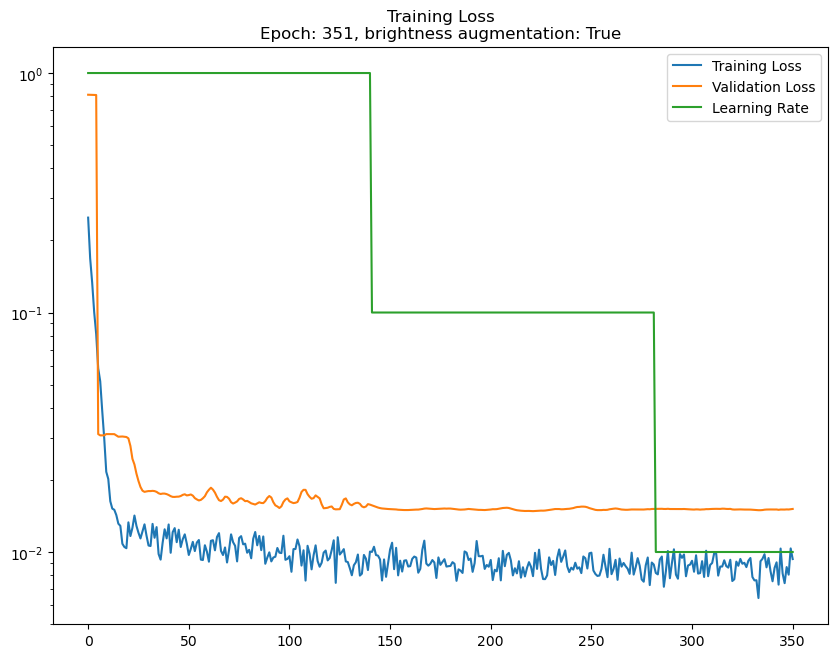

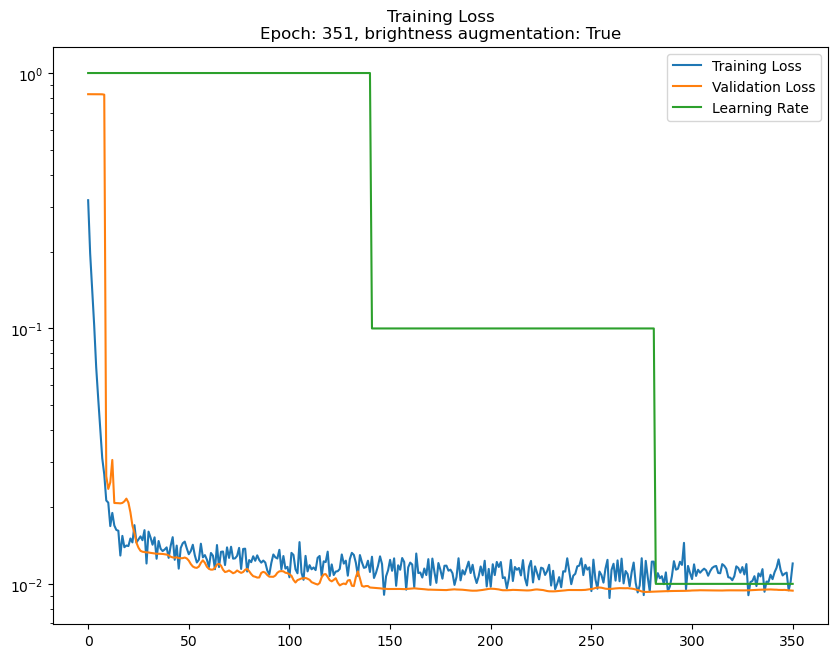

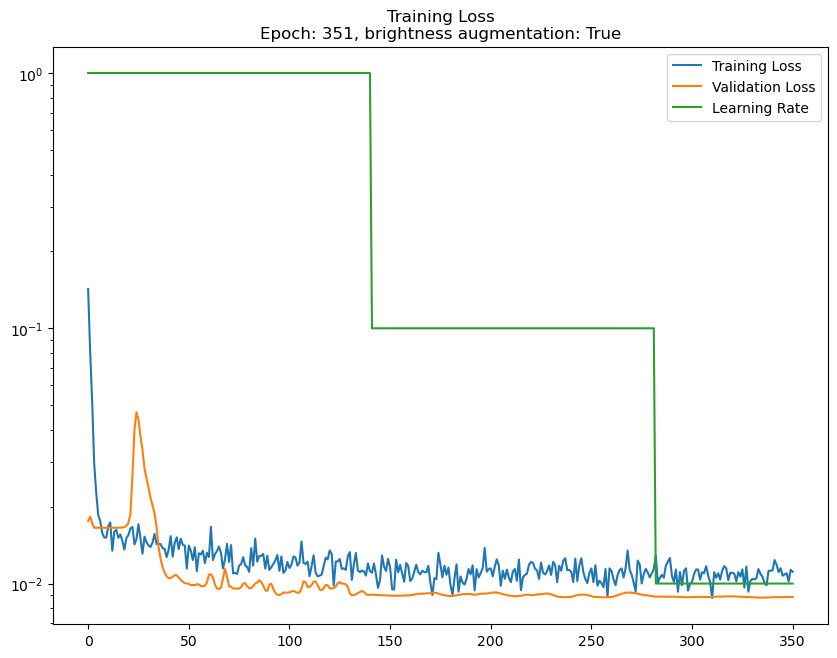

/gpfs/space/home/eckhardt/cellnet/results/train/240715-212232-bright-rmbad-RUNNING/cellnet/plot.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


In [5]:

# def count(y): return yunnorm(y).sum().item()
def accuracy(y,z): 
  ny, nz = y.sum().item(), z.sum().item()
  return 1 - abs(ny - nz) / (nz+1e-9)

def train(epochs, model, optim, lossf, sched, kp2hm, traindl, valdl=None, info={}):
  log = pd.DataFrame(columns='tl vl ta va lr'.split(' '), index=range(epochs))
  def epoch(dl, train):
    l = 0; a = 0; b = 0
    for b, B in enumerate(dl):
      x,m = B['image'].to(device), B['masks'][0].to(device)
      z = kp2hm(B).to(device)

      y = model(x)
      loss = lossf(y*m, z*m) 
      l += loss.item()
      a += accuracy(y*m, z*m)

      if train:
        loss.backward()
        optim.step()
        optim.zero_grad()

    return l/(b+1), a/(b+1)

  for e in range(epochs):
    log.loc[e,'lr'] = optim.param_groups[0]['lr']
  
    model.train()
    log.loc[e,'tl'], log.loc[e,'ta'] = epoch(traindl, train=True)
    sched.step() 
  
    if valdl is not None: 
      model.eval()
      with torch.no_grad():
        log.loc[e,'vl'], log.loc[e,'va'] = epoch(valdl, train=False) 

    if MODE=='draft': plot.train_graph(e, log, info=info, key2text=key2text, clear=True)
  plot.train_graph(epochs, log, info=info, key2text=key2text, accuracy=False) 
  return log

# time the function and print its duration
import time
def timeit(f):
  def timed(*args, **kw):
    ts = time.time()
    result = f(*args, **kw)
    te = time.time()
    print(f'{f.__name__} took {te-ts} seconds')
    return result
  return timed

@timeit
def loss_per_point(b, lossf, kernel=15, exclude=[]):
  loss = lossf.__class__(reduction='none')(*[torch.tensor(x) for x in [b.y, b.z]])
  p2L = np.zeros(len(b.l))
  for i, (l, (x,y)) in enumerate(zip(b.l, b.k)):
    #if l in exclude: continue  # NOTE hack to exclude losses for negative annotations (TODO reevaluate why)
    xx, yy = np.meshgrid(np.arange(loss.shape[2]), np.arange(loss.shape[1]))
    k = (xx-x)**2 + (yy-y)**2 < kernel**2
    p2L[i] = (loss * k).sum()

  return p2L


results = pd.DataFrame()
if not MODE=='draft': [os.makedirs(_p, exist_ok=True) for _p in ('preds', 'plots')]

def training_run(cfg, traindl, valdl, kp2hm, model=None):
  global results  
  p = cfg.__dict__[P]
  ti = cfg.ti; vi = cfg.vi

  if model is None: model = mk_model()
  optim = torch.optim.Adam(model.parameters(), lr=5e-3)
  lossf = dict(
    MSE = torch.nn.MSELoss(),
    BCE = torch.nn.BCELoss(),
    Focal = smp.losses.FocalLoss('binary'),
    MCC = smp.losses.MCCLoss(),
    Dice = smp.losses.DiceLoss('binary', from_logits=False),
  )[cfg.lossf]
  # TODO implement label smoothing?

  sched = torch.optim.lr_scheduler.StepLR(optim, step_size=int(cfg.epochs/cfg.lr_steps)+1, gamma=cfg.lr_gamma)

  log = train(cfg.epochs, model, optim, lossf, sched, kp2hm, traindl, valdl, info={P: p})

  _row =  pd.DataFrame(dict(**{P: [p]}, ti=[ti], vi=[vi], **log.iloc[-1]))
  results = _row if results.empty else pd.concat([results, _row], ignore_index=True)
  # TODO CHECK is the saved accuracy correct? Because model ran on sanger reports counts ({'data/4.jpg': 1335.7061956439575, 'data/2.jpg': 1477.7731458703638, 'data/1.jpg': 1791.7817114729842, 'data/3.jpg': 1916.6642587431998}) that are only 0.787571807701338 (0.9790417598444654, 0.7550352604295545, 0.6286384028299937) 


  i2p2L = {}
  # plot and save predictions to disk
  for ii, t in [(ti, 'T'), (vi, 'V')]:
    for i in ii:
      B = next(iter(mk_loader([i], bs=1, transforms=mkAugs('test'), shuffle=False, cfg=cfg)))

      model.eval()
      with torch.no_grad(): y = cpu(model(B['image'].to(device)))
      b = batch2cpu(B, z=kp2hm(B), y=y)[0]
      del B

      if cfg.rmbad != 0: # get the badly predicted points and plot them
        p2L = loss_per_point(b, lossf, kernel=15, exclude=[2])
        if MODE=='release' or i in vi: 
          i2p2L[i] = p2L  # only save the losses for the validation image 

        #np.save(f'p2L-{imgid(i)}.npy', p2L)  # DEBUG dump p2L to disk for later analysis
        #print(f'DEBUG: saved point losses for val image {i} (should happen only once per cfg and image)')

      if (MODE=='release' or [imgid(_v) for _v in vi]==['4']) and (imgid(i) in ('1','4')):  # plot T1 and V4 for all [1,2]|[4] runs
        ax1 = plot.overlay(b.x, b.y, b.m, b.k, b.l, cfg.sigma) 
        ax2 = plot.diff   (b.y, b.z, b.m, b.k, b.l, cfg.sigma)
        ax3 = None

        if cfg.rmbad != 0: 
          rm = np.argsort(-i2p2L[i])[:int(len(b.l)*cfg.rmbad)]  # type: ignore
          ax3 = plot.image(b.x); plot.points(ax3, b.k, b.l)
          for a in (ax1, ax2, ax3):
            plot.points(a, b.k[rm], b.l[rm], colormap='#00ff00', lw=3)
           
        if not MODE=='draft': 
          id = f"{P}={p}-{t}{imgid(i)}"
          #np.save(f'preds/{id}.npy', y)
          plot.save(ax1, f'plots/{id}.pred.png')
          plot.save(ax2, f'plots/{id}.diff.png')
          if ax3 is not None: plot.save(ax3, f'plots/{id}.points.png')
          plt.close('all') # save but don't show

  return dict(model=model, log=log, i2p2L=i2p2L)

# mode == 2 => aka test augs => no cropping
def get_loader(cfg, ti, vi, mode):
  loader = lambda m, ids: (m:=min(m,2), mk_loader(ids, bs=1 if m==2 else 16, shuffle=False, cfg=cfg, transforms=mkAugs(m)))[-1]
  return [loader(mode, ti), loader(mode+1, vi) if vi is not None and len(vi)>0 else None]
kp2hm, yunnorm, _ymax = mk_kp2mh_yunnorm(cfg_base)

for p in [ps[-1]] if MODE=='draft' else ps:
  cfg = obj(**(cfg_base.__dict__ | {P: p}))
  if P in ['sigma']: kp2hm, yunnorm, _ymax = mk_kp2mh_yunnorm(cfg)

  i2p2L = {}

  for ti, vi in data_splits:
    cfg = obj(**(cfg.__dict__ | dict(ti=ti, vi=vi)))

    traindl, valdl = get_loader(cfg, ti, vi, AUG_MODE)

    out = training_run(cfg, traindl, valdl, kp2hm)
    i2p2L |= out['i2p2L'] # NOTE: overrides if image in multiple val sets

  if cfg.rmbad != 0:  # remove the bad points and retrain
    keep = {i: np.argsort(-p2L)[int(len(p2L)*cfg.rmbad):] for i,p2L in i2p2L.items()} 
    
    for _i, k in keep.items(): print(f"DEBUG: keeping {len(k)} of {len(i2p2L[_i])} points for {_i}")

    for ti, vi in data_splits:
      cfg = obj(**(cfg.__dict__ | dict(ti=ti, vi=vi, epochs=cfg.epochs//2+1, rmbad=0.1)))

      traindl, valdl = get_loader(cfg, ti, vi, AUG_MODE)

      def regen_masks(dl):
        ds: CellnetDataset = dl.dataset # type: ignore
        _old_ds_P_len = {i: len(ds.P[i]) for i in ds.P}
        _keep_len = {i: len(keep[i]) for i in keep}
        ds.P = {i: ds.P[i][keep[i]] for i in ds.P}
        ds.L = {i: ds.L[i][keep[i]] for i in ds.L}
        _mid_ds_P_len = {i: len(ds.P[i]) for i in ds.P}
        ds._generate_masks(fraction=1, sparsity=1)
        _new_ds_P_len = {i: len(ds.P[i]) for i in ds.P}
        # regenerate masks, but don't throw away more data (f,s=1)
        # NOTE: because we do it for each split repeatedly its a waste of compute. More efficient: to do it once but would need a bigish refactor
        for i in ds.P:
          print(f"DEBUG: regen_masks {i}: P: {_old_ds_P_len[i]} - {_keep_len[i]} = {_mid_ds_P_len[i]} = {_new_ds_P_len[i]}")

        # plot the new masks
        for i,B in enumerate(mk_loader(image_paths='all', cfg=cfg, bs=1, transforms=mkAugs('test'), shuffle=False)):
          b = batch2cpu(B, z=kp2hm(B))[0]
          ax = plot.overlay(b.x, b.z, b.m, b.k, b.l, cfg.sigma)
          if not MODE=='draft': 
            plot.save(ax, f'plots/regen_masks-{i}.png')
            plt.close(ax.get_figure())
      
      regen_masks(traindl)
      if valdl: regen_masks(valdl)

      out = training_run(cfg, traindl, valdl, kp2hm, 
                         model=out['model'])  # type: ignore

In [6]:
if MODE=='release': # save model to disk
  B = next(iter(mk_loader(['data/1.jpg'], cfg=cfg_base, bs=1, transforms=mkAugs('test'), shuffle=False)))
  x = batch2cpu(B)[0].x[None]
  
  m = out['model'] # type: torch.nn.Module # type: ignore 
  m.eval()

  # save a test in/out
  #os.makedirs(cachedir:=os.path.expanduser('~/.cache/cellnet'), exist_ok=True)
  np.save('./model_export_test_x_1.npy', x)
  np.save('./model_export_test_y_1.npy', cpu(m(gpu(x, device=device))))

  m.save_pretrained('./model_export')  # specific to master branch of SMP. TODO: make more robust with onnx. But see problem notes in cellnet.yml
  os.remove('./model_export/README.md')

  # convert all ndarray to list for json serialization
  def rec_dict_array2list(d):
    for k,v in d.items():
      if isinstance(v, dict): rec_dict_array2list(v)
      if isinstance(v, np.ndarray): d[k] = v.tolist()
  settings = rec_dict_array2list(cfg_base.__dict__ | {'ymax':float(_ymax)})

  with open('./model_export/settings.json', 'w') as f:  json.dump(settings, f, indent=2)

,brightness augmentation,ti,vi,tl,vl,ta,va,lr
0,True,"[data/2.jpg, data/4.jpg]",[data/1.jpg],0.009344,0.015128,0.964888,0.771388,0.01
1,True,"[data/1.jpg, data/4.jpg]",[data/2.jpg],0.012020,0.009407,0.967757,0.846603,0.01
2,True,"[data/1.jpg, data/2.jpg]",[data/4.jpg],0.011124,0.008865,0.973323,0.847913,0.01


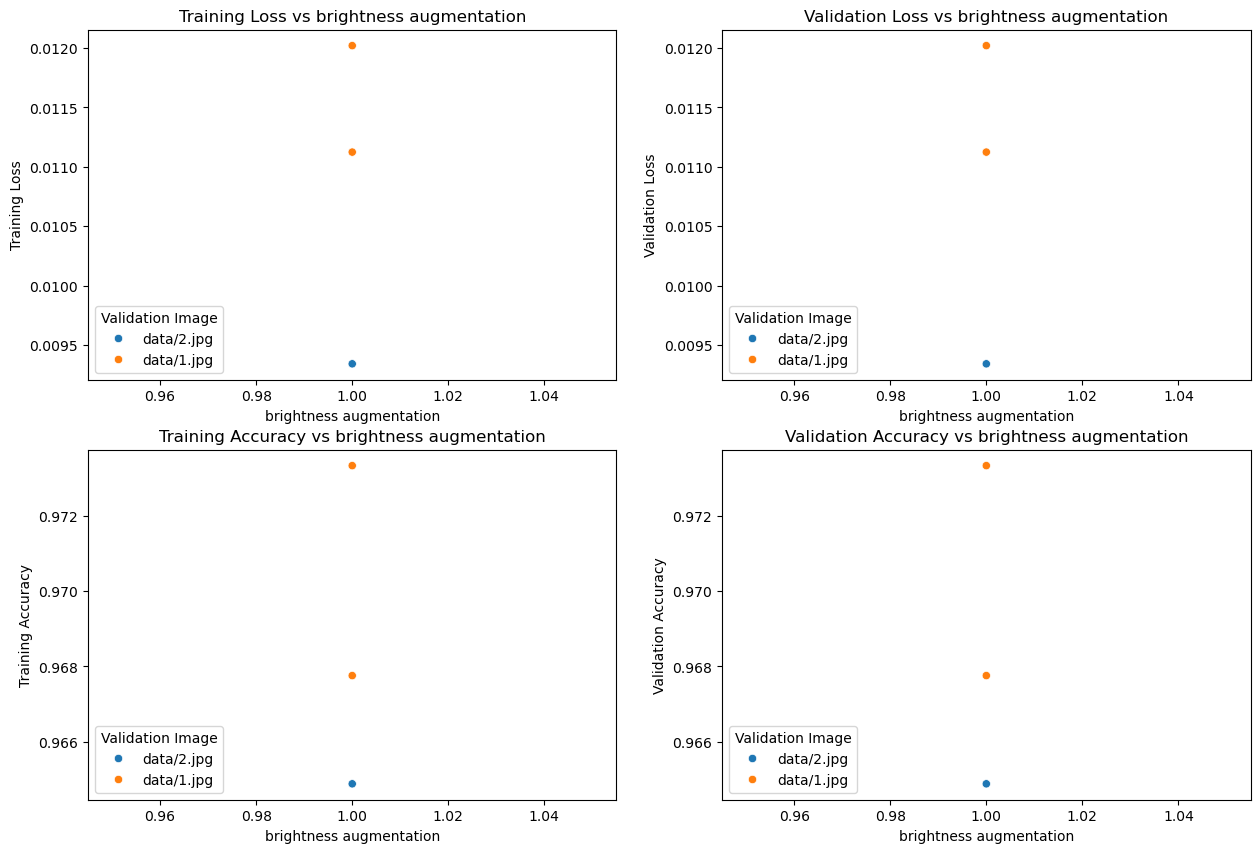

In [7]:

if not MODE=='draft':
  results.to_csv('results.csv', index=False, sep=';')
  R = results.copy()
  R['vi'] = R['ti']; R['vl'] = R['tl']; R['va'] = R['ta']   # HACK because in RELEASE vi=[]
  R.rename(columns=dict(vi=key2text['vi']), inplace=True)
  plot.regplot(R, P, key2text)

results # type: ignore